In [1]:
# import some libraries
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
# load the dataset
num_classes = 10 
cifar10 = tf.keras.datasets.cifar10
(x_learn, y_learn),(x_test, y_test) = cifar10.load_data()


# Normalize the data in [0 1]
print("Normalizing training set..")
x_learn = np.asarray(x_learn, dtype=np.float32) / 255 # Normalizing training set
print("Normalizing test set..")
x_test = np.asarray(x_test, dtype=np.float32) / 255 # Normalizing test set

Normalizing training set..
Normalizing test set..


In [3]:
# split in training and validation
x_train, x_val, y_train, y_val = train_test_split(x_learn, y_learn, test_size=0.25, random_state=12)

In [4]:
# Standardizing the data
def standardize_dataset(X):
    image_means = []
    image_stds = []

    for image in X:
        image_means.append(np.mean(image)) # Computing the image mean
        image_stds.append(np.std(image)) # Computing the image standard deviation

    dataset_mean = np.mean(image_means) # Computing the dataset mean
    dataset_std = np.mean(image_stds) # Computing the dataset standard deviation
    return [dataset_mean, dataset_std] # For every image we subtract to it the dataset mean and we divide by the dataset standard deviation

dataset_mean, dataset_std = standardize_dataset(x_train)

print("Standardizing training set..")
x_train = (x_train-dataset_mean)/dataset_std # Standardizing the training set
print("Standardizing validation set..")
x_val = (x_val-dataset_mean)/dataset_std # Standardizing the test set
print("Standardizing test set..")
x_test = (x_test-dataset_mean)/dataset_std # Standardizing the test set

# one hot encode target values
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

print("Size of the training set")
print("x_train", x_train.shape)
print("y_train", y_train.shape)

print("Size of the validation set")
print("x_val", x_val.shape)
print("y_val", y_val.shape)

print("Size of the test set")
print("x_test", x_test.shape)
print("y_test", y_test.shape)

Standardizing training set..
Standardizing validation set..
Standardizing test set..
Size of the training set
x_train (37500, 32, 32, 3)
y_train (37500, 10)
Size of the validation set
x_val (12500, 32, 32, 3)
y_val (12500, 10)
Size of the test set
x_test (10000, 32, 32, 3)
y_test (10000, 10)


#### Plot some sample from the training set

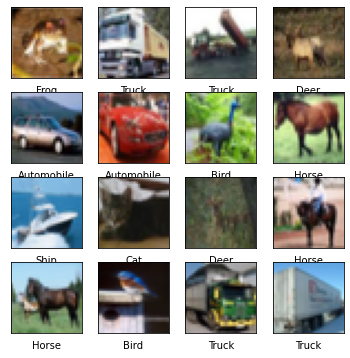

In [5]:

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_learn[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_learn[i,0]])
plt.show()

In [6]:
from tensorflow import keras 
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Dense
from keras import layers,regularizers
from keras.layers import Dropout,BatchNormalization

tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


l2_norm = .0001

# Add a Dense layer with number of neurons equal to the number of classes, with softmax as activation function
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(BatchNormalization())
## you may add here dense layers, using fo instance model.add(Dense(64, activation='relu'))
model.add(Dense(768,activation='elu',kernel_initializer='he_normal',
                kernel_regularizer=regularizers.l2(l2_norm)))
model.add(BatchNormalization())
model.add(Dropout(.2))
model.add(Dense(384,activation='elu',kernel_initializer='he_normal',
                kernel_regularizer=keras.regularizers.l2(l2_norm)))
model.add(BatchNormalization())
model.add(Dropout(.5))
model.add(Dense(num_classes, activation='softmax'))

In [7]:
from keras.optimizers import Adam, SGD, Adadelta, Adagrad, Adamax, Nadam, RMSprop
adamax = Adamax(learning_rate=0.002,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0)
nadam = Nadam(learning_rate=0.002,beta_1=0.9,beta_2=0.999,epsilon=None,schedule_decay=0.004)
sgd = SGD(learning_rate=0.001, momentum=0.09, decay=0.0000, nesterov=True,clipvalue=1)
loss = ['categorical_crossentropy']

metrics = ['accuracy']



In [8]:
model.compile(optimizer=nadam,
              loss=loss[0],
              metrics=[metrics[0]],
              )

In [10]:
batch_size = 64
epochs = 300
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
import os

es_callback = EarlyStopping(monitor='val_accuracy', patience=10,verbose=1)
#lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

checkpoint_path = "output1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(checkpoint_path,monitor='val_accuracy',save_best_only=True)
from pathlib import Path
from time import strftime
def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")
run_logdir = get_run_logdir() # e.g., my_logs/run_2022_08_01_17_25_59

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(x_train, y_train, batch_size=batch_size, validation_data =(x_val, y_val),epochs=epochs,
                    callbacks=[es_callback,cp_callback,tensorboard_cb])

Epoch 1/300
586/586 [==============================] - 48s 81ms/step - loss: 1.6849 - accuracy: 0.4911 - val_loss: 1.6528 - val_accuracy: 0.5034
Epoch 2/300
586/586 [==============================] - 49s 83ms/step - loss: 1.6650 - accuracy: 0.4951 - val_loss: 1.6290 - val_accuracy: 0.5051
Epoch 3/300
586/586 [==============================] - 43s 73ms/step - loss: 1.6487 - accuracy: 0.5017 - val_loss: 1.6317 - val_accuracy: 0.5007
Epoch 4/300
586/586 [==============================] - 48s 81ms/step - loss: 1.6323 - accuracy: 0.5042 - val_loss: 1.6064 - val_accuracy: 0.5104
Epoch 5/300
586/586 [==============================] - 44s 75ms/step - loss: 1.6146 - accuracy: 0.5054 - val_loss: 1.6013 - val_accuracy: 0.5098
Epoch 6/300
262/586 [============>.................] - ETA: 20s - loss: 1.5896 - accuracy: 0.5116

In [ ]:
keras.models.load_model('output1\\cp.ckpt')

In [ ]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

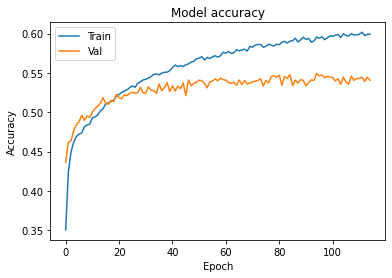

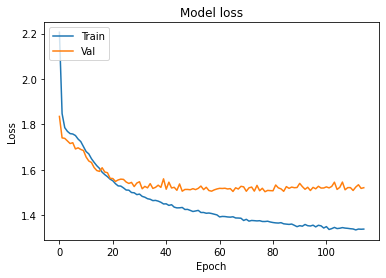

In [ ]:
plot_history(history)

## Evaluate the model


In [ ]:
_, train_acc = model.evaluate(x_train, y_train, verbose=1)
_, val_acc = model.evaluate(x_val, y_val, verbose=1)

_, test_acc = model.evaluate(x_test, y_test, verbose=1)
print('Train: %.3f, val: %.3f,Test: %.3f' % (train_acc,val_acc, test_acc))

313/313 [==============================] - 2s 6ms/step - loss: 1.5008 - accuracy: 0.5504
Train: 0.712, val: 0.541,Test: 0.550
